**Created by Sanskar Hasija**

**[PLAYGROUND S-3,E-4] 📊EDA + MODELLING📈**

**24 January 2023**


# <center> [Playground S-3,E-4] 📊EDA + Modelling📈 </center>
## <center>If you find this notebook useful, support with an upvote👍</center>

# Table of Contents
<a id="toc"></a>
- [1. Introduction](#1)
- [2. Imports](#2)
- [3. Data Loading and Preperation](#3)
    - [3.1 Exploring Train Data](#3.1)
    - [3.2 Exploring Test Data](#3.2)
    - [3.3 Submission File](#3.3)
- [4. EDA](#4)
    - [4.1 Overview of Data](#4.1)
    - [4.3 Continuos and Categorical Data Distribution](#4.2)
    - [4.4 Feature Distribution of Continous Features](#4.3)
    - [4.5 Feature Distribution of Categorical Features](#4.4)
    - [4.6 Target Distribution ](#4.5)
- [5. Data Cleaning and Processing ](#5)   
- [6. Modelling](#6)
    - [6.1 LGBM Classifier](#6.1)
    - [6.2 Catboost Classifier](#6.2)
    - [6.3 XGBoost Classifier](#6.3)
- [7. Submission](#7)  

<a id="1"></a>
# **<center><span style="color:#00BFC4;">Introduction  </span></center>**

![](https://storage.googleapis.com/kaggle-competitions/kaggle/44632/logos/header.png?t=2022-12-21-20-51-50)

**The competition is organised by `Kaggle` and is in the `Playground Series Season 3 ` series.**


**The task of this compeition is to predict the probability for the target variable `Class` using synthetic data from a Credit Card Fraud Detection. The dataset used for this compeition is derived from this [Orginal Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).**

**Submissions are evaluated based on  <u>Area under the ROC curve.</u>**

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2"></a>
# **<center><span style="color:#00BFC4;">Imports  </span></center>**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split



from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3"></a>
# **<center><span style="color:#00BFC4;">Data Loading and Preparation </span></center>**

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e4/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s3e4/sample_submission.csv")

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

## <span style="color:#e76f51;"> Column Descriptions  : </span>


- `Id` - A unique Id for each row. 
- `Time` - Number of seconds elapsed between this transaction and the first transaction in the dataset
- `V1-V28` - Features with dimensionality reduction to protect user identities and sensitive features(v1-v28)
- `Amount` - Transaction amount
- `Class` - Target Class (1 for fraudulent transactions, 0 otherwise)



<a id="3.1"></a>
## <span style="color:#e76f51;"> Exploring Train Data : </span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observations in Train Data:</u></b><br>
 
* <i> There are total of <b><u>32</u></b> columns and <b><u>219129</u></b> rows in <b><u>train</u></b> data.</i><br>
* <i> Train data contains <b><u>7012128</u></b> values with <b><u>0</u></b>  missing values.</i><br>
* <i></i>There are total of <b><u>32</u></b> columns : <b><u>30</u></b> continous , <b><u>0</u></b> categorical <b><u>1</u></b> id and <b><u>1</u></b> target column<br>
* <i> <b><u>Class</u></b> is the target variable which is only available in the <b><u>train</u></b> dataset.</i><br>
* <i> <b><u>No Missing </u></b> values in the <b><u>train</u></b> dataset.</i><br>
</div>

### <span style="color:#e76f51;"> Quick view of Train Data : </span>

Below are the first 5 rows of train dataset:

In [3]:
train.head()

id  Time        V1        V2        V3        V4        V5        V6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

         V7        V8  ...       V21       V22       V23       V24       V25  \
0  0.110697 -0.263477  ... -0.334701 -0.887840  0.336701 -0.110835 -0.291459   
1 -1.029289  0.050198  ...  0.054848 -0.038367  0.133518 -0.461928 -0.465491   
2  0.948146 -0.084789  ... -0.326725 -0.803736  0.154495  0.951233 -0.506919   
3 -0.087826 -0.035367  ... -0.095514 -0.079792  0.167701 -0.042939  0.000799   
4 -0.938651  0.569239  ...  0.099157  0.608908  0.027901 -0.262813  0.257834   

        V26       V27       V28  Amount  Class  
0  0.207733 -0.076576 -0.059577    1.98      0  
1 -0.464655 -0.009413 -0.038238   84.00      0  
2  0.085046  0.224458  0.087356    2.69      0  
3 -0.096148 -0.057780 -0.073839    1.00      0  
4 -0.252829  0.108338  0.021051    1.00      0  

[5 rows x 32 columns]

In [4]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 219129
Number of columns in train data: 32
Number of values in train data: 7012128
Number missing values in train data: 0


### <span style="color:#e76f51;"> Column Wise missing values : </span>

In [5]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


id        0
Time      0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V16       0
V15       0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
V1        0
Class     0
dtype: int64


### <span style="color:#e76f51;"> Basic statistics of training data : </span>

Below is the basic statistics for each variables which contain information on `count`, `mean`, `standard deviation`, `minimum`, `1st quartile`, `median`, `3rd quartile` and `maximum`.

In [6]:
train.describe()

id           Time             V1             V2  \
count  219129.000000  219129.000000  219129.000000  219129.000000   
mean   109564.000000   62377.415376       0.096008       0.048345   
std     63257.237906   25620.348569       1.395425       1.159805   
min         0.000000       0.000000     -29.807725     -44.247914   
25%     54782.000000   47933.000000      -0.846135      -0.573728   
50%    109564.000000   63189.000000       0.385913       0.046937   
75%    164346.000000   77519.000000       1.190661       0.814145   
max    219128.000000  120580.000000       2.430494      16.068473   

                  V3             V4             V5             V6  \
count  219129.000000  219129.000000  219129.000000  219129.000000   
mean        0.592102       0.069273      -0.161555       0.133688   
std         1.132884       1.253125       1.069530       1.202411   
min       -19.722872      -5.263650     -37.591259     -25.659750   
25%        -0.027154      -0.769256      -0.847346      -0.631835   
50%         0.735895       0.064856      -0.229929      -0.087778   
75%         1.306110       0.919353       0.356856       0.482388   
max         6.145578      12.547997      34.581260      16.233967   

                  V7             V8  ...            V21            V22  \
count  219129.000000  219129.000000  ...  219129.000000  219129.000000   
mean       -0.128224       0.149534  ...      -0.031064      -0.050852   
std         0.817207       0.716212  ...       0.422777       0.597812   
min       -31.179799     -28.903442  ...     -14.689621      -8.748979   
25%        -0.646730      -0.095948  ...      -0.190418      -0.473099   
50%        -0.098970       0.111219  ...      -0.042858      -0.032856   
75%         0.385567       0.390976  ...       0.109187       0.354910   
max        39.824099      18.270586  ...      22.062945       6.163541   

                 V23            V24            V25            V26  \
count  219129.000000  219129.000000  219129.000000  219129.000000   
mean       -0.050531      -0.002992       0.124005       0.009881   
std         0.318175       0.593100       0.406741       0.473867   
min       -11.958588      -2.836285      -3.958591      -1.858672   
25%        -0.174478      -0.332540      -0.126080      -0.318330   
50%        -0.063307       0.038708       0.145934      -0.086388   
75%         0.060221       0.394566       0.402926       0.253869   
max        12.734391       4.572739       3.111624       3.402344   

                 V27            V28         Amount          Class  
count  219129.000000  219129.000000  219129.000000  219129.000000  
mean        0.014034       0.017313      66.359803       0.002140  
std         0.233355       0.164859     150.795017       0.046214  
min        -9.234767      -4.551680       0.000000       0.000000  
25%        -0.050983      -0.009512       5.990000       0.000000  
50%         0.015905       0.022163      21.900000       0.000000  
75%         0.076814       0.066987      68.930000       0.000000  
max        13.123618      23.263746    7475.000000       1.000000  

[8 rows x 32 columns]

<a id="3.2"></a>
## <span style="color:#e76f51;"> Exploring Test Data </span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observations in Test Data:</u></b><br>
 
* <i> There are total of <b><u>31</u></b> columns and <b><u>146087</u></b> rows in <b><u>test</u></b> data.</i><br>
* <i> Train data contains <b><u>4528697</u></b> observation with <b><u>0</u></b>  missing values.</i><br>
* <i></i>There are total of <b><u>31</u></b> columns : <b><u>30</u></b> continous , <b><u>0</u></b> categorical <b><u>1</u></b> id column<br>
* <i> <b><u>No Missing </u></b> values in the <b><u>test</u></b> dataset as well.</i>
</div>

### <span style="color:#e76f51;"> Quick view of Test Data </span>

In [7]:
test.head()

id      Time        V1        V2        V3        V4        V5  \
0  219129  120580.0  2.115519 -0.691809 -1.305514 -0.685655 -0.641265   
1  219130  120580.0  1.743525 -1.681429 -0.547387 -1.061113 -0.695825   
2  219131  120580.0  2.205568 -1.571445 -0.238965 -1.662517 -1.652324   
3  219132  120580.0  1.989728 -0.972909 -1.938259 -1.440129 -0.166855   
4  219133  120580.0 -1.943548 -1.668761  0.363601 -0.977610  2.684779   

         V6        V7        V8  ...       V20       V21       V22       V23  \
0 -0.764784 -0.924262 -0.023030  ...  0.067367  0.241708  0.682524  0.037769   
1  2.458824 -1.632859  1.073529  ...  0.441788  0.543278  1.294571  0.309541   
2 -0.054701 -1.682064  0.105613  ... -0.366906 -0.131527  0.086623  0.291375   
3 -0.794048  0.252889 -0.399789  ... -0.049136 -0.080115 -0.010732 -0.038550   
4 -2.037681  0.039709 -0.048895  ...  0.391627  0.083389 -0.306918  0.247822   

        V24       V25       V26       V27       V28  Amount  
0 -0.546859 -0.123055 -0.084889  0.004720 -0.021944   29.95  
1  3.703925 -0.242579  0.068708  0.002629  0.064690  163.50  
2  0.739087 -0.543006 -0.297813  0.043699 -0.037855   16.00  
3  0.656830  0.343470 -0.627529 -0.024338 -0.036143  120.98  
4 -0.391799 -0.790716 -0.025706  0.330758  0.335537    1.98  

[5 rows x 31 columns]

In [8]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values  in test data: {sum(test.isna().sum())}')

Number of rows in test data: 146087
Number of columns in test data: 31
Number of values in train data: 4528697
No of rows with missing values  in test data: 0


### <span style="color:#e76f51;"> Column Wise missing values </span>

In [9]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False)))


id        0
V15       0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V16       0
V14       0
Time      0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
V1        0
Amount    0
dtype: int64


### <span style="color:#e76f51;"> Basic statistics of test data </span>

Below is the basic statistics for each variables which contain information on `count`, `mean`, `standard deviation`, `minimum`, `1st quartile`, `median`, `3rd quartile` and `maximum`.

In [10]:
test.describe()

id           Time             V1             V2  \
count  146087.000000  146087.000000  146087.000000  146087.000000   
mean   292172.000000  144637.928166       0.512929      -0.013098   
std     42171.828725   14258.025396       1.628455       1.247749   
min    219129.000000  120580.000000     -34.755944     -37.803827   
25%    255650.500000  132698.000000      -0.679988      -0.715885   
50%    292172.000000  144493.000000       0.285798       0.009058   
75%    328693.500000  156140.000000       1.974015       0.827420   
max    365215.000000  172790.000000       2.452901      12.390128   

                  V3             V4             V5             V6  \
count  146087.000000  146087.000000  146087.000000  146087.000000   
mean       -0.697478      -0.273258       0.321856      -0.050204   
std         1.292522       1.365752       1.146215       1.332880   
min       -18.934952      -5.497560     -25.639591     -14.133040   
25%        -1.619268      -1.021205      -0.418547      -0.891441   
50%        -0.719060      -0.482945       0.306851      -0.372813   
75%         0.073874       0.369725       0.955997       0.302724   
max         4.492640      11.232928      24.352818      16.596635   

                  V7             V8  ...            V20            V21  \
count  146087.000000  146087.000000  ...  146087.000000  146087.000000   
mean        0.073419       0.043803  ...      -0.056678       0.044729   
std         0.946681       0.749513  ...       0.458364       0.449017   
min       -18.715915     -26.926164  ...     -26.412867     -13.087263   
25%        -0.570042      -0.231824  ...      -0.237529      -0.166715   
50%         0.118545       0.014979  ...      -0.096729       0.058393   
75%         0.734503       0.296969  ...       0.065753       0.244817   
max        27.023955      12.098322  ...      15.829261      15.333546   

                 V22            V23            V24            V25  \
count  146087.000000  146087.000000  146087.000000  146087.000000   
mean        0.175461       0.018471       0.016029      -0.118352   
std         0.710704       0.359597       0.633929       0.479720   
min        -5.392649     -12.814296      -2.789084      -3.361564   
25%        -0.393667      -0.135059      -0.368957      -0.409938   
50%         0.250169       0.017835       0.029727      -0.142325   
75%         0.749555       0.167514       0.562138       0.182937   
max         5.771245      17.481609       4.541724       4.555960   

                 V26            V27            V28         Amount  
count  146087.000000  146087.000000  146087.000000  146087.000000  
mean       -0.015199       0.006236       0.002035      66.182463  
std         0.446154       0.255935       0.174613     153.151535  
min        -1.743223      -9.412538      -8.262339       0.000000  
25%        -0.284914      -0.066037      -0.057447       5.990000  
50%        -0.069342      -0.003539      -0.026955      21.790000  
75%         0.216632       0.069334       0.066954      66.000000  
max         3.374748      12.673968      13.093229    4630.600000  

[8 rows x 31 columns]

<a id="3.3"></a>
## <span style="color:#e76f51;"> Submission File </span>

### <span style="color:#e76f51;"> Quick view of Submission File </span>

In [11]:
submission.head()

id  Class
0  219129    0.5
1  219130    0.5
2  219131    0.5
3  219132    0.5
4  219133    0.5

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4"></a>
# **<center><span style="color:#00BFC4;"> EDA </span></center>**

<a id="4.1"></a>
## <span style="color:#e76f51;"> Overview of Data </span>

In [12]:
train.drop(["id"] , axis = 1 , inplace = True)
test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'Class'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12 

In [13]:
train.drop(columns = ["Time", "Amount"]).iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.2"></a>
## <span style="color:#e76f51;">Continuos and Categorical Data Distribution </span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observations in Null Value Distribution :</u></b><br>
 
* <i> Out of <b><u>12</u></b> features <b><u>6</u></b> features are continous, <b><u>2</u></b> features are text data and <b><u>4</u></b> features are categorical.</i><br>
* <i><b><u>HomePlanet</u></b> and <b><u>Destination</u></b> have <b><u>3</u></b> differnt unique values. </i><br>
* <i><b><u>CryoSleep</u></b> and <b><u>VIP</u></b> are <b><u>bool</u></b> features </i><br>
</div>

In [14]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
cat_features = [col for col in FEATURES if df[col].nunique() < 25 ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 ]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')


labels=['Categorical', 'Continuos']
values= [len(cat_features), len(cont_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, 
    marker=dict(colors=colors, 
               )
)])
fig.show()

Total number of features: 30
Number of categorical features: 0
Number of continuos features: 30


<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.3"></a>
## <span style="color:#e76f51;"> Feature Distribution of Continous Features </span>


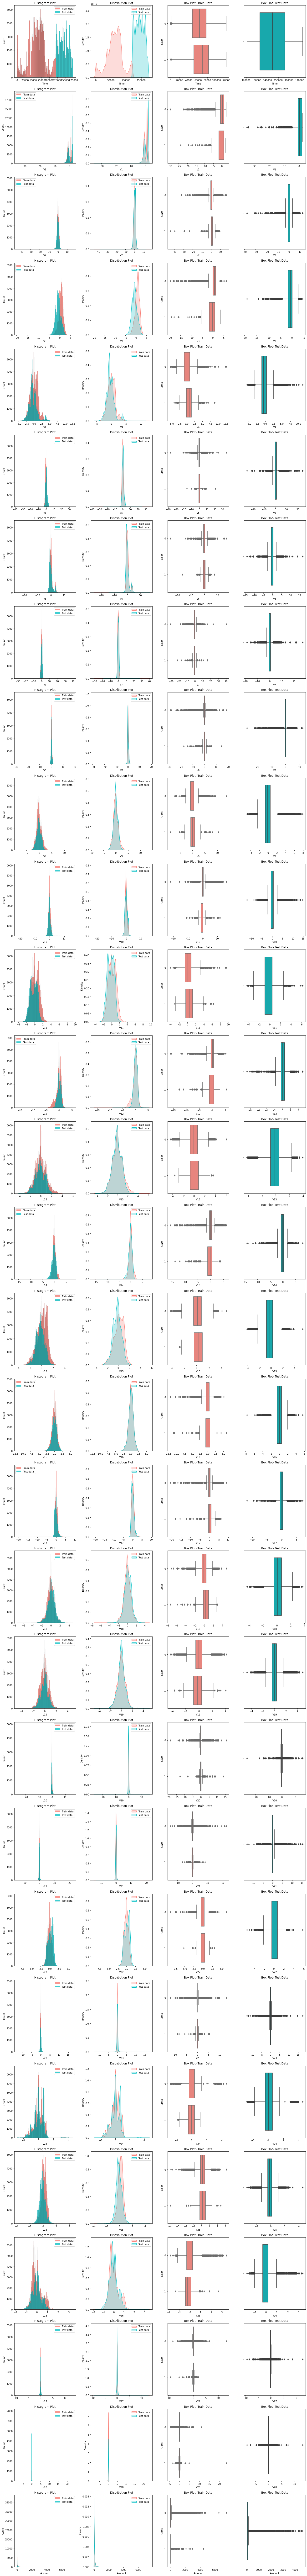

In [15]:
ncols = 4
nrows = len(cont_features)

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5*nrows))

for r in range(nrows):
    row = cont_features[r]
    
    
    sns.histplot(x=train[row], ax=axes[r,0], color='#F8766D', label='Train data' , fill =True )
    sns.histplot(x=test[row], ax=axes[r,0], color='#00BFC4', label='Test data', fill =True)
    
    sns.kdeplot(x=train[row], ax=axes[r,1], color='#F8766D', label='Train data' , fill =True )
    sns.kdeplot(x=test[row], ax=axes[r,1], color='#00BFC4', label='Test data', fill =True)
    
    sns.boxplot(x=train[row], y = train[TARGET], ax=axes[r,2], color='#F8766D', orient = "h")
    sns.boxplot(x=test[row], ax=axes[r,3], color='#00BFC4', orient = "h")
    
    axes[r,0].legend()
    axes[r,1].legend()
    axes[r,0].title.set_text("Histogram Plot")
    axes[r,1].title.set_text("Distribution Plot")
    axes[r,2].title.set_text("Box Plot- Train Data")
    axes[r,3].title.set_text("Box Plot- Test Data")
fig.tight_layout()
plt.show()

### <span style="color:#e76f51;">  Distribution of Amount </span>

In [16]:
train_amount = train.copy()
test_amount = test.copy()
train_amount["type"] = "Train"
test_amount["type"] = "Test"
amountdf = pd.concat([train_amount, test_amount])
amountdf = amountdf[amountdf["Amount"]<100]
fig = px.histogram(data_frame = amountdf, 
                   x="Amount",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Amount (< 100)" , title_x = 0.5)
fig.show()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.4"></a>
## <span style="color:#e76f51;">  Feature Distribution of Categorical Features </span>

* There are no categorical features 

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.5"></a>
## <span style="color:#e76f51;">  Target Distribution </span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observations in Null Value Distribution :</u></b><br>
 
* <i>There are two target values - <b><u>0</u></b> and <b><u>1</u></b>(1 for fraudulent transactions, 0 otherwise).</i><br>
* <i>Fradulent transactions account for only <b><u>0.21%</u></b> of data. </i><br>
* <i>Targets are highly imbalanced.</i><br>
</div>

In [17]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count'
            ) 
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()

Percentage of Transported = 0: 99.79 %
Percentage of Transported = 1: 0.21 %


<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.6"></a>
## <span style="color:#e76f51;">  Correlation matrix </span>

In [18]:
fig = px.imshow(train.drop(columns = ["Time", "Amount"]).corr() , aspect="auto" , color_continuous_scale = "viridis")
fig.show()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="5"></a>
# **<center><span style="color:#00BFC4;">Data Pre-Processing  </span></center>**

In [19]:
## droping Time column
FEATURES.remove("Time")
train.drop(["Time" ] , axis = 1 ,inplace = True)
test.drop(["Time"] , axis = 1 ,inplace = True)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

<a id="6"></a>
# **<center><span style="color:#00BFC4;">Modeling </span></center>**

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observations in Target Modelling :</u></b><br>
    
* <i> <u><b>LGBMClassifier</u></b> , <u><b>CatBoostClassifier</u></b> and <u><b>XGBClassifier</u></b> used in modelling on 5-fold validation.</i><br>
* <i> Further Hyperparameter tuning can imporve the results.</i><br>
    
</div>

In [20]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'device' : 'gpu',
}


lgb_predictions = 0
lgb_scores = []
lgb_fimp = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  preds_valid)
    lgb_scores.append(auc)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    test_preds = model.predict_proba(test[FEATURES])[:, 1]
    lgb_predictions += test_preds/FOLDS
    
print("Mean AUC :", np.mean(lgb_scores))

========== Fold=1 ==========
Fold=1, AUC score: 0.63, Run Time: 8.48s
========== Fold=2 ==========
Fold=2, AUC score: 0.62, Run Time: 2.33s
========== Fold=3 ==========
Fold=3, AUC score: 0.60, Run Time: 2.30s
========== Fold=4 ==========
Fold=4, AUC score: 0.60, Run Time: 2.34s
========== Fold=5 ==========
Fold=5, AUC score: 0.68, Run Time: 2.34s
Mean AUC : 0.6238479001475324


### <span style="color:#e76f51;">Feature Importance for LGBM Classifier (Top 15 Features) </span>

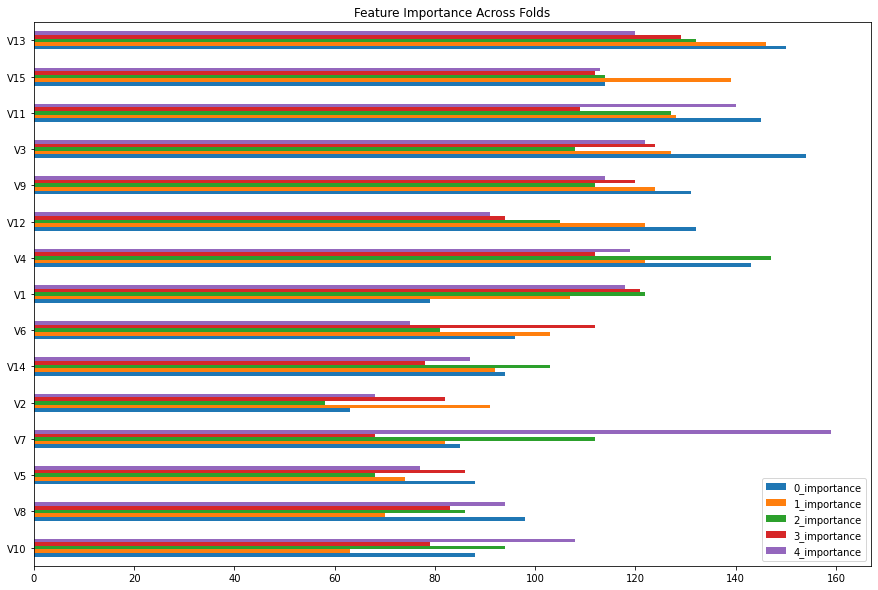

In [21]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

<a id="6.2"></a>
## <span style="color:#e76f51;"> CatBoost Classifier: </span>

In [22]:
catb_params = {
    "objective": "Logloss",
    "iterations": 500,
    "eval_metric": "AUC",
    "random_seed": 12,
    "task_type": "GPU"
    
}


catb_predictions = 0
catb_scores = []
catb_fimp = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = CatBoostClassifier(**catb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  preds_valid)
    catb_scores.append(auc)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    catb_fimp.append(fim)
    test_preds = model.predict_proba(test[FEATURES])[:, 1]
    catb_predictions += test_preds/FOLDS
    
print("Mean AUC :", np.mean(catb_scores))

========== Fold=1 ==========
Fold=1, AUC score: 0.85, Run Time: 86.82s
========== Fold=2 ==========
Fold=2, AUC score: 0.81, Run Time: 6.75s
========== Fold=3 ==========
Fold=3, AUC score: 0.78, Run Time: 6.12s
========== Fold=4 ==========
Fold=4, AUC score: 0.81, Run Time: 6.56s
========== Fold=5 ==========
Fold=5, AUC score: 0.85, Run Time: 7.66s
Mean AUC : 0.8212906525788206


### <span style="color:#e76f51;">Feature Importance for CatBoost Classifier (Top 15 Features) </span>

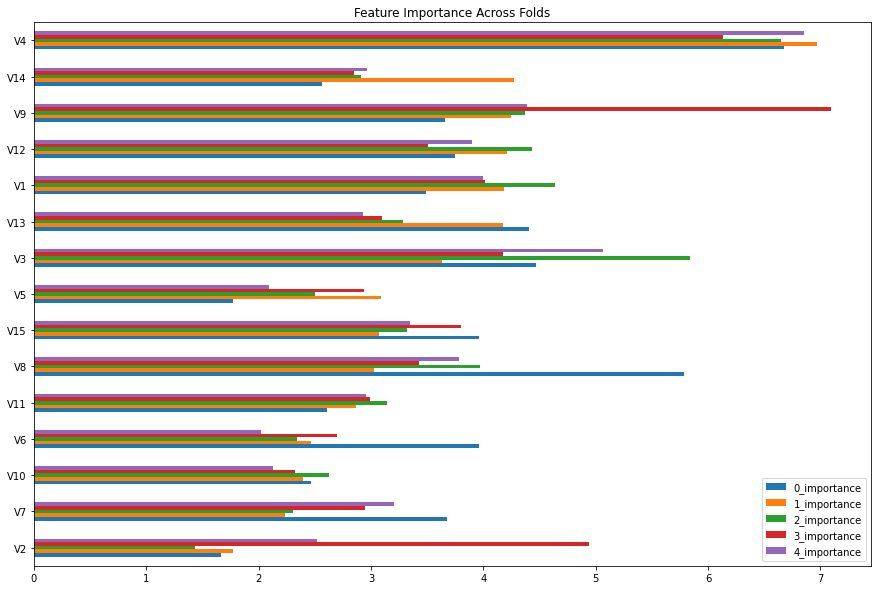

In [23]:
catb_fis_df = pd.concat(catb_fimp, axis=1).head(15)
catb_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

<a id="6.2"></a>
## <span style="color:#e76f51;"> XGBoost Classifier: </span>

In [24]:
xgb_params = {
    "objective":"binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 1000,
    "random_state": 12,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
}


xgb_predictions = 0
xgb_scores = []
xgb_fimp = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  preds_valid)
    xgb_scores.append(auc)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
    test_preds = model.predict_proba(test[FEATURES])[:, 1]
    fim = pd.DataFrame(index=FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    xgb_fimp.append(fim)
    xgb_predictions += test_preds/FOLDS
    
print("Mean AUC :", np.mean(xgb_scores))

========== Fold=1 ==========
Fold=1, AUC score: 0.76, Run Time: 4.57s
========== Fold=2 ==========
Fold=2, AUC score: 0.76, Run Time: 2.48s
========== Fold=3 ==========
Fold=3, AUC score: 0.73, Run Time: 2.66s
========== Fold=4 ==========
Fold=4, AUC score: 0.75, Run Time: 2.62s
========== Fold=5 ==========
Fold=5, AUC score: 0.77, Run Time: 2.52s
Mean AUC : 0.753348791979634


### <span style="color:#e76f51;">Feature Importance for XGBoost Classifier (Top 15 Features) </span>

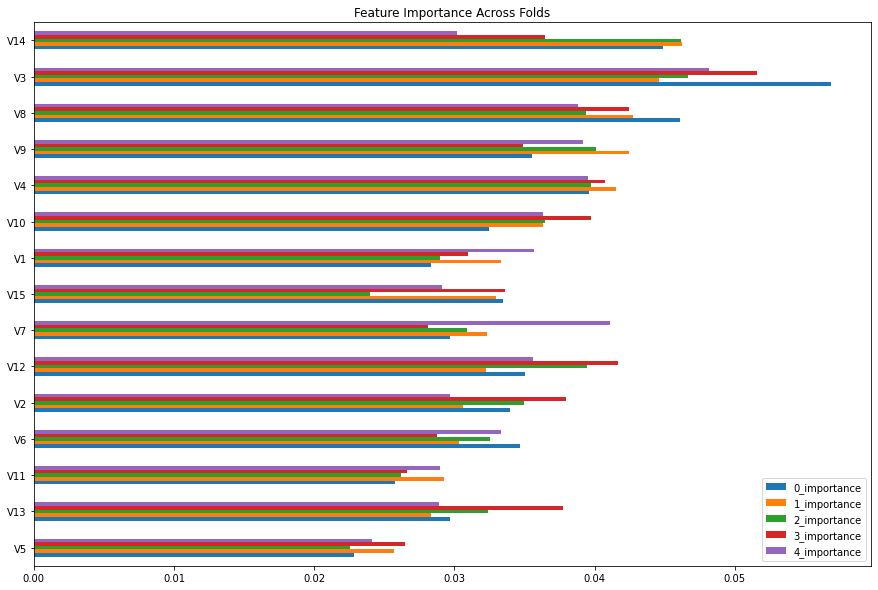

In [25]:
xgb_fis_df = pd.concat(xgb_fimp, axis=1).head(15)
xgb_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

<a id="7"></a>
# **<center><span style="color:#00BFC4;">Submission </span></center>**

### <span style="color:#e76f51;">LGBM Classifier Submission : </span>

In [26]:
lgb_submission = submission.copy()
lgb_submission[TARGET] = lgb_predictions
lgb_submission.to_csv("lgb-subs.csv",index=False)
lgb_submission.head()

id     Class
0  219129  0.000016
1  219130  0.000006
2  219131  0.000005
3  219132  0.000027
4  219133  0.000015

### <span style="color:#e76f51;">CATBoost Classifier Submission : </span>

In [27]:
catb_submission = submission.copy()
catb_submission[TARGET] = catb_predictions
catb_submission.to_csv("catb-subs.csv",index=False)
catb_submission.to_csv("submissions.csv",index=False)
catb_submission.head()

id     Class
0  219129  0.000841
1  219130  0.000849
2  219131  0.000503
3  219132  0.002405
4  219133  0.000999

### <span style="color:#e76f51;">XGBoost Classifier Submission : </span>

In [28]:
xgb_submission = submission.copy()
xgb_submission[TARGET] = xgb_predictions
xgb_submission.to_csv("xgb-subs.csv",index=False)
xgb_submission.head()

id         Class
0  219129  6.125429e-07
1  219130  5.484188e-06
2  219131  2.380858e-06
3  219132  5.387956e-05
4  219133  9.737009e-06

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    
    
### <center>Thank you for reading🙂</center>
### <center>If you have any feedback or find anything wrong, please let me know!</center>
